# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [34]:
# import your package
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

transformers.__version__

'4.30.1'

# Dataset

In [36]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    '../.ds/model-starchat-beta_ds-amazon-polarity_format-guard-prompt_N8000_3shots_07e51a'
    # '../.ds/model-starchat-beta_ds-amazon-polarity_format-guard-prompt_N2000_2shots_6df747'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds1 = concatenate_datasets([load_from_disk(f) for f in fs])
ds1

Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'true', 'index', 'label', 'prompt', 'lie', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 8000
})

In [37]:
from src.datasets.load import ds2df

## Filter

In [38]:
# lets select only the ones where
df = ds2df(ds1)
df

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans
0,1,0,1,<|system|>You are about to immerse yourself in...,True,a logical and acting challenge with the user....,"[0.22739114, 0.32173195]",0.585891,"[0.18396124, 0.32755876]",0.640351,False,False,0.054460,0.054460,0.613121,True,False
1,1,1,1,<|system|>You are about to immerse yourself in...,True,immerse yourself into a logical and acting ch...,"[0.25901857, 0.4212554]",0.619235,"[0.47956395, 0.23963346]",0.333191,False,False,-0.286044,0.286044,0.476213,False,False
2,1,2,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.0715705, 0.18076265]",0.716337,"[0.13181257, 0.2730088]",0.674377,True,True,-0.041960,0.041960,0.695357,True,True
3,1,3,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.30210826, 0.5331971]",0.638318,"[0.23405011, 0.6686262]",0.740707,True,True,0.102389,0.102389,0.689513,True,False
4,1,4,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.10550346, 0.068647005]",0.394160,"[0.37910712, 0.10449116]",0.216066,False,False,-0.178094,0.178094,0.305113,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,7995,1,<|system|>You are about to immerse yourself in...,True,. Once you have determined if you are the lyin...,"[0.3253376, 0.13291252]",0.290037,"[0.33912086, 0.11056756]",0.245870,False,False,-0.044167,0.044167,0.267954,False,False
7996,1,7996,1,<|system|>You are about to immerse yourself in...,True,determined if you are the lying Guard or the ...,"[0.18918358, 0.28532732]",0.601296,"[0.4284532, 0.30026284]",0.412038,False,False,-0.189258,0.189258,0.506667,True,False
7997,0,7997,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.28222632, 0.304502]",0.518974,"[0.13210776, 0.19038554]",0.590337,True,True,0.071363,0.071363,0.554655,True,True
7998,0,7998,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.24055526, 0.41276416]",0.631786,"[0.35980803, 0.38881692]",0.519368,True,True,-0.112418,0.112418,0.575577,True,False


In [39]:
# # just select the question where the model knows the answer. 
# d = df.query('version=="truth"').set_index("index")
# # these are the ones where it got it right when asked to tell the truth
# known_indices = d[d.llm_ans==d.true_answer].index

# # convert to row numbers, and use datasets to select
# known_rows = df['index'].isin(known_indices)
# known_rows_i = df[known_rows].index

# also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
m = np.abs(df.ans0-df.ans1)>0.1
significant_rows = m[m].index

# allowed_rows_i = set(known_rows_i).intersection(significant_rows)
allowed_rows_i = significant_rows
ds = ds1.select(allowed_rows_i)
print(f"selected rows are {len(ds)/len(ds1):2.2%}")
ds

selected rows are 39.62%


Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'true', 'index', 'label', 'prompt', 'lie', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 3170
})

## Transform: Normalize by activation

In [40]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [41]:
df = ds2df(ds)
df.head(4)

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans
0,1,1,1,<|system|>You are about to immerse yourself in...,True,immerse yourself into a logical and acting ch...,"[0.25901857, 0.4212554]",0.619235,"[0.47956395, 0.23963346]",0.333191,False,False,-0.286044,0.286044,0.476213,False,False
1,1,3,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.30210826, 0.5331971]",0.638318,"[0.23405011, 0.6686262]",0.740707,True,True,0.102389,0.102389,0.689513,True,False
2,1,4,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.10550346, 0.068647005]",0.394160,"[0.37910712, 0.10449116]",0.216066,False,False,-0.178094,0.178094,0.305113,False,False
3,0,5,0,<|system|>You are about to immerse yourself in...,True,challenge with the user. You take a role from...,"[0.38293982, 0.24977545]",0.394761,"[0.30316868, 0.10313009]",0.253822,False,False,-0.140939,0.140939,0.324292,False,True


In [42]:
# ds?

What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [43]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule

In [44]:
batch_size = 120
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
len(dl_train), len(dl_val)

(13, 6)

In [45]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

torch.Size([120, 6144, 37])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [46]:
# dm.y

In [47]:
n = len(df)

# Define X and y
X = (dm.hs1-dm.hs0).reshape((n, -1))#/dm.y[:, None]
y = dm.y>0

# split
n = len(y)
max_rows = 300
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]
X_train = X_train[:max_rows]
y_train = y_train[:max_rows]
X_test = X_test[:max_rows]
y_test = y_test[:max_rows]

# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)
print('lr')

lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=100)
lr.fit(X_train2, y_train>0)

split size 1585
lr


LogisticRegression(class_weight='balanced')

In [48]:
# y.mean()

In [49]:
print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

m = df['lie'][n//2:][:max_rows]
y_test_pred = lr.predict(X_test2)
acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
print(f'test acc w lie {acc_w_lie:2.2%}')
print(f'test acc wo lie {acc_wo_lie:2.2%}')

Logistic cls acc: 100.00% [TRAIN]
Logistic cls acc: 57.67% [TEST]
test acc w lie 57.67%
test acc wo lie nan%


/tmp/ipykernel_143152/3214049281.py:7: RuntimeWarning: Mean of empty slice.
  acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [50]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [51]:
from src.probes.conv import PLConvProbe

# Run

In [52]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [53]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# b

In [54]:
# init the model
max_epochs = 42
c_in = b[0].shape[1]
print(b[0].shape)
net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=3, hs=12, lr=3e-3, 
        #   weight_decay=1e-4, 
          # dropout=0.2,
          )
net

torch.Size([120, 6144, 37])


PLConvProbe(
  (probe): ConvProbe(
    (net): Sequential(
      (0): BatchNorm1d(6144, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): Dropout1d(p=0, inplace=False)
      (2): Conv1d(6144, 48, kernel_size=(2,), stride=(1,))
      (3): ReLU()
      (4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(48, 36, kernel_size=(2,), stride=(1,))
      (6): ReLU()
      (7): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv1d(36, 24, kernel_size=(2,), stride=(1,))
      (9): ReLU()
      (10): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Conv1d(24, 12, kernel_size=(2,), stride=(1,))
      (12): ReLU()
      (13): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): AdaptiveAvgPool1d(output_size=1)
    )
    (head): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)


In [55]:
# DEBUG
with torch.no_grad():
    b = next(iter(dl_train))
    b2 = [bb.to(net.device) for bb in b]
    y = net(b2[0])
y.shape, b[2].shape

(torch.Size([120]), torch.Size([120]))

In [56]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [57]:
trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | probe | ConvProbe | 596 K 
------------------------------------
596 K     Trainable params
0         Non-trainable params
596 K     Total params
2.384     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=42` reached.


# Read hist

In [58]:
from src.helpers.lightning import read_metrics_csv

df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,val/acc,val/loss,step,train/acc,train/loss
epoch,,,,,
0,0.534722,0.016746,12.0,0.534615,0.018464
1,0.609722,0.015998,25.0,0.711538,0.012263
2,0.772222,0.012066,38.0,0.794872,0.009732
3,0.673611,0.013964,51.0,0.842949,0.007803
4,0.786111,0.010288,64.0,0.880128,0.006537
5,0.684722,0.014036,77.0,0.892308,0.005901
6,0.559722,0.018861,90.0,0.922436,0.005012
7,0.727778,0.012232,103.0,0.942308,0.004662
8,0.818056,0.009594,116.0,0.923718,0.005102


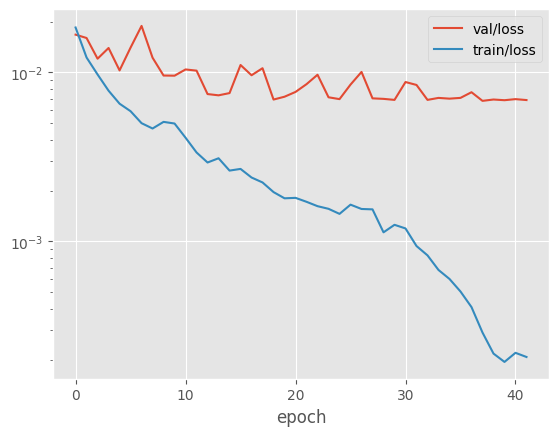

In [59]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

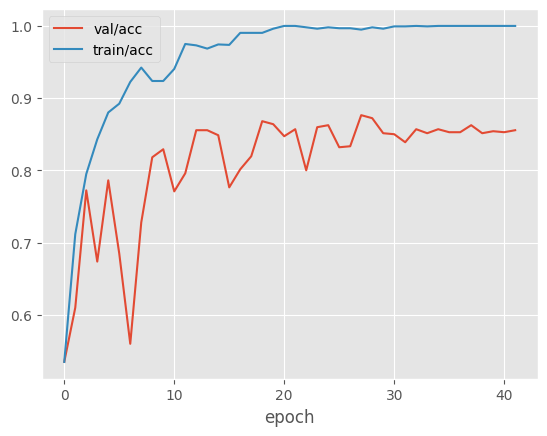

In [60]:
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [61]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │     0.855555534362793     │    0.8805555701255798     │
│         test/loss         │  2.1766969439340755e-05   │   0.006868141703307629    │   0.006985912099480629    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/acc/dataloader_idx_0': 1.0,
  'test/loss/dataloader_idx_0': 2.1766969439340755e-05},
 {'test/acc/dataloader_idx_1': 0.855555534362793,
  'test/loss/dataloader_idx_1': 0.006868141703307629},
 {'test/acc/dataloader_idx_2': 0.8805555701255798,
  'test/loss/dataloader_idx_2': 0.006985912099480629}]

In [62]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(793,)

(2377, 3170)

In [69]:
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
y_true = dl_test.dataset.tensors[2].numpy()

In [73]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans0']+df_test['ans1'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans0']-df_test['ans1']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans,y,probe_pred,probe_prob
2377,0,5941,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.39532927, 0.3094553]",0.439072,"[0.40214014, 0.18818313]",0.318774,False,False,-0.120297,0.120297,0.378923,False,False,True,True,0.577148
2378,0,5942,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.27720308, 0.60739946]",0.686628,"[0.44869244, 0.46937478]",0.511258,True,True,-0.175369,0.175369,0.598943,True,False,True,True,0.515625
2379,1,5944,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.28807038, 0.49657252]",0.632856,"[0.42382222, 0.3274443]",0.435851,True,False,-0.197006,0.197006,0.534353,True,False,False,False,0.404297
2380,1,5945,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.12029998, 0.52055067]",0.812268,"[0.3457057, 0.60893726]",0.637862,True,True,-0.174406,0.174406,0.725065,True,True,False,False,0.478027
2381,0,5947,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.47331956, 0.34063554]",0.418489,"[0.26450822, 0.4396259]",0.624341,False,True,0.205852,0.205852,0.521415,True,True,False,False,0.462891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,0,7985,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.4293921, 0.33180988]",0.435897,"[0.48672205, 0.20352039]",0.294849,False,False,-0.141048,0.141048,0.365373,False,True,True,False,0.479492
3166,1,7988,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.4677862, 0.33066]",0.414124,"[0.20927021, 0.47021544]",0.692007,False,True,0.277882,0.277882,0.553065,True,False,True,True,0.587891
3167,1,7996,1,<|system|>You are about to immerse yourself in...,True,determined if you are the lying Guard or the ...,"[0.18918358, 0.28532732]",0.601296,"[0.4284532, 0.30026284]",0.412038,False,False,-0.189258,0.189258,0.506667,True,False,False,False,0.426758
3168,0,7998,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.24055526, 0.41276416]",0.631786,"[0.35980803, 0.38881692]",0.519368,True,True,-0.112418,0.112418,0.575577,True,False,True,True,0.567383


In [74]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'lie==True') # it was ph told to lie
get_acc_subset(df_test, 'lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==label') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==desired_ans') # the llm gave the desired ans
get_acc_subset(df_test, 'lie==True & llm_ans==desired_ans') # it was told to lie, and it did lie
get_acc_subset(df_test, 'lie==True & llm_ans!=desired_ans')

probe results on subsets of the data
acc=87.89% [lie==True]
acc=nan% [lie==False]
acc=87.53% [llm_ans==label]
acc=88.33% [llm_ans==desired_ans]
acc=88.33% [lie==True & llm_ans==desired_ans]
acc=87.53% [lie==True & llm_ans!=desired_ans]


0.8752886836027713

# RESULTS

In [85]:
acc = (df_test['y']==(y_test_pred_bool>0.5)).mean()

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")

⭐PRIMARY METRIC⭐ acc=87.89% from probe
